In [1]:
import os
import dotenv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
from supabase import create_client, Client
dotenv.load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [9]:
response = supabase.table("electricitymaps-hourly").select("*").eq("testing", False).execute()

In [8]:
response.data[0].keys()

dict_keys(['id', 'created_at', 'zone', 'carbon_intensity_raw', 'power_breakdown_raw', 'testing'])

In [10]:
len(response.data)

51

In [12]:
response.data[0].keys()

dict_keys(['id', 'created_at', 'zone', 'carbon_intensity_raw', 'power_breakdown_raw', 'testing'])

In [16]:
response.data[0]['carbon_intensity_raw']['history']

[{'zone': 'CA-ON',
  'datetime': '2024-08-12T04:00:00.000Z',
  'createdAt': '2024-08-09T04:54:32.766Z',
  'updatedAt': '2024-08-12T08:48:58.186Z',
  'isEstimated': True,
  'carbonIntensity': 49,
  'estimationMethod': 'TIME_SLICER_AVERAGE',
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T05:00:00.000Z',
  'createdAt': '2024-08-09T05:50:06.777Z',
  'updatedAt': '2024-08-12T07:50:29.597Z',
  'isEstimated': False,
  'carbonIntensity': 44,
  'estimationMethod': None,
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T06:00:00.000Z',
  'createdAt': '2024-08-09T06:49:22.181Z',
  'updatedAt': '2024-08-12T08:48:58.186Z',
  'isEstimated': False,
  'carbonIntensity': 40,
  'estimationMethod': None,
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T07:00:00.000Z',
  'createdAt': '2024-08-09T07:48:50.341Z',
  'updatedAt': '2024-08-12T09:50:15.226Z',
  'isEstimated': False,
  'carbonIntensity': 42,
  

In [21]:
# Generate a big ol' dataframe by iterating over all the responses
all_records = pd.DataFrame.from_records([
    record
    for resp in response.data
    for record in resp['carbon_intensity_raw']['history']
])
all_records.loc[all_records.zone == "CA-ON"].sort_values(by='datetime', ascending=True)


,zone,datetime,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
0,CA-ON,2024-08-12T04:00:00.000Z,2024-08-09T04:54:32.766Z,2024-08-12T08:48:58.186Z,True,49,TIME_SLICER_AVERAGE,lifecycle
72,CA-ON,2024-08-12T05:00:00.000Z,2024-08-09T05:50:06.777Z,2024-08-12T07:50:29.597Z,False,44,None,lifecycle
1,CA-ON,2024-08-12T05:00:00.000Z,2024-08-09T05:50:06.777Z,2024-08-12T07:50:29.597Z,False,44,None,lifecycle
2,CA-ON,2024-08-12T06:00:00.000Z,2024-08-09T06:49:22.181Z,2024-08-12T08:48:58.186Z,False,40,None,lifecycle
144,CA-ON,2024-08-12T06:00:00.000Z,2024-08-09T06:49:22.181Z,2024-08-12T08:48:58.186Z,False,40,None,lifecycle
...,...,...,...,...,...,...,...,...
1031,CA-ON,2024-08-13T17:00:00.000Z,2024-08-10T17:48:24.105Z,2024-08-13T16:48:42.001Z,True,137,TIME_SLICER_AVERAGE,lifecycle
1173,CA-ON,2024-08-13T17:00:00.000Z,2024-08-10T17:48:24.105Z,2024-08-13T18:48:45.181Z,False,142,None,lifecycle
1174,CA-ON,2024-08-13T18:00:00.000Z,2024-08-10T18:46:52.632Z,2024-08-13T18:48:45.181Z,True,149,TIME_SLICER_AVERAGE,lifecycle
1103,CA-ON,2024-08-13T18:00:00.000Z,2024-08-10T18:46:52.632Z,2024-08-13T17:46:40.545Z,True,145,TIME_SLICER_AVERAGE,lifecycle


In [22]:
all_records.loc[all_records.zone == "CA-ON"].groupby("datetime").count()

,zone,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
datetime,,,,,,,
2024-08-12T04:00:00.000Z,1,1,1,1,1,1,1
2024-08-12T05:00:00.000Z,2,2,2,2,2,0,2
2024-08-12T06:00:00.000Z,3,3,3,3,3,0,3
2024-08-12T07:00:00.000Z,4,4,4,4,4,0,4
2024-08-12T08:00:00.000Z,5,5,5,5,5,0,5
2024-08-12T09:00:00.000Z,6,6,6,6,6,0,6
2024-08-12T10:00:00.000Z,7,7,7,7,7,0,7
2024-08-12T11:00:00.000Z,8,8,8,8,8,0,8
2024-08-12T12:00:00.000Z,9,9,9,9,9,0,9


In [23]:
all_records.loc[
    (all_records.zone == "CA-ON") & (all_records.datetime == "2024-08-12T19:00:00.000Z")
]

,zone,datetime,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
15,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
86,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
157,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
228,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
299,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
370,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
441,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
512,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
583,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle
654,CA-ON,2024-08-12T19:00:00.000Z,2024-08-09T19:48:45.216Z,2024-08-12T21:45:53.909Z,False,121,None,lifecycle


In [28]:
all_records.drop_duplicates().groupby(["zone", "datetime"])['carbonIntensity'].count().sort_values(ascending=False)

zone        datetime                
US-NE-ISNE  2024-08-13T05:00:00.000Z    9
CA-ON       2024-08-13T05:00:00.000Z    8
US-NE-ISNE  2024-08-13T08:00:00.000Z    7
            2024-08-13T09:00:00.000Z    6
            2024-08-13T06:00:00.000Z    6
                                       ..
            2024-08-12T10:00:00.000Z    1
            2024-08-12T09:00:00.000Z    1
            2024-08-12T08:00:00.000Z    1
            2024-08-12T07:00:00.000Z    1
US-NW-WACM  2024-08-13T19:00:00.000Z    1
Name: carbonIntensity, Length: 120, dtype: int64

In [30]:
all_records.drop_duplicates().query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'").drop_duplicates()

,zone,datetime,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
191,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T04:49:46.210Z,True,305,TIME_SLICER_AVERAGE,lifecycle
262,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T05:50:39.779Z,False,293,None,lifecycle
333,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T06:48:50.859Z,False,293,None,lifecycle
404,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T07:50:00.045Z,False,293,None,lifecycle
688,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T11:50:27.541Z,False,293,None,lifecycle
759,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T12:52:34.364Z,False,293,None,lifecycle
901,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T14:47:43.254Z,False,293,None,lifecycle
972,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T15:48:12.136Z,False,293,None,lifecycle
1043,US-NE-ISNE,2024-08-13T05:00:00.000Z,2024-08-10T05:52:08.413Z,2024-08-13T16:48:42.001Z,False,293,None,lifecycle


In [38]:
# Within each zone,datetime group, select the record with maximum updatedAt value
idx = all_records.groupby(["zone", "datetime"])['updatedAt'].idxmax()
filtered_records = all_records.loc[idx].reset_index(drop=True)

datetime_cols = ["datetime", "createdAt", "updatedAt"]
filtered_records[datetime_cols] = filtered_records[datetime_cols].apply(pd.to_datetime)

In [39]:
filtered_records.query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'")

/var/folders/vd/5pm1cb6x2c96t008wh13s61h0000gn/T/ipykernel_85664/3393552696.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, UTC] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_records.query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'")


,zone,datetime,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
65,US-NE-ISNE,2024-08-13 05:00:00+00:00,2024-08-10 05:52:08.413000+00:00,2024-08-13 16:48:42.001000+00:00,False,293,None,lifecycle


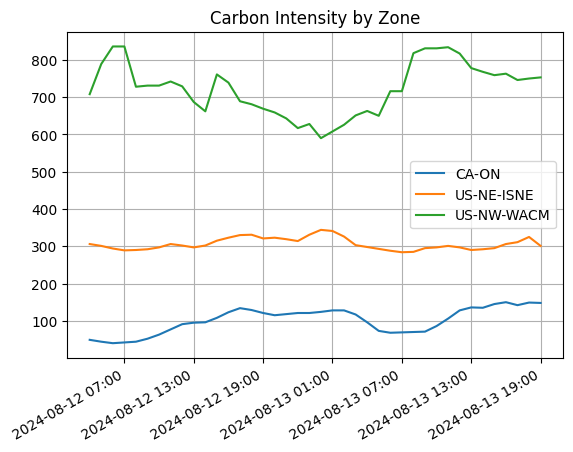

In [45]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()

for zone in filtered_records.zone.unique():
    zone_data = filtered_records.loc[filtered_records.zone == zone]
    ax.plot(zone_data.datetime, zone_data.carbonIntensity, label=zone)

ax.legend()
# Set major locator to every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))

# Set major formatter to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Optional: rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Optional: add grid for better readability
ax.grid(True)
ax.set_title("Carbon Intensity by Zone")

fig.autofmt_xdate()
plt.show()

In [37]:
filtered_records.datetime.iloc[0]

'2024-08-12T04:00:00.000Z'